# Dynamic Value Iteration Planning
By: Edwin Hartnell

## Acknowledgements

Based upon the *Better Markov Decision Process (MDP) Tools* ([bettermdptools](https://github.com/jlm429/bettermdptools)) by John Mansfield et al. And based upon the [Gym API](https://www.gymlibrary.dev/) for reinforcement learning. The example below was adapted from the [Frozen Lake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) example.

## The Why

Self-driving vehicles know where they are located, and they know the location of their goal. They can use planning algorithms like Value Iteration to calculate a set of driving directions based upon an optimal policy. But the vehicle can also learn on the way. It can encounter unknown obstacles and be forced to adjust its policy.

This Jupyter Workbook provides example code that can be adapted into a real-world experiment for a robotic kit car.

## Demonstration

Below is a demonstration of this algorithm running on real hardware:

- [TurboPi Robotic Car by HiWonder - Product Link](https://www.hiwonder.com/collections/robotic-car/products/turbopi?variant=40112905388119)

- [TurboPi Hardware - Heuristic Planning - Source Code](https://github.com/tedhartnell/ai4r-turbopi/blob/main/Heuristic_Planning.py)

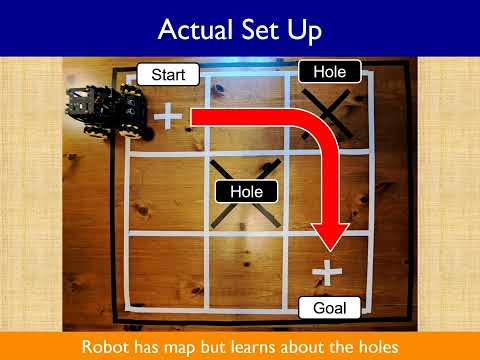

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('524vXAc4aBo', width=800, height=600)

## Grid World

In this experiment, an 8x8 grid world is provided for the robotic kit car. There is a starting location (labeled 'S') and a goal location (labeled 'G'). While there may be many holes in the road along the way, the robot does not yet know about these. It only knows the starting location and the goal, and it calculates an initial optimal path based upon what it knows. But as the robot encounters each hole, it must re-evaluate its optimal policy and come up with a new plan.

While this code is self-contained and can run without robotic hardware, it could be adapted for a real-world experiment by taping out a grid on the floor. Black tape can mark out holes in the road, and the robotic car can identify these holes and avoid them using its Line Detector hardware.

![Grid World Planning](images/grid-world-planning-002.png)

## Required Hardware

In addition to the Line Detector underneath the robot, this experiment also suits robotic kit cars with **mecanum wheels**. These allow the car to move left, right, forwards, and backwards without turning. This simulates the north, south, east, and west directions followed on the map.

![Robotic Kit Car with Mecanum Wheels](images/mecanum-wheels-003.jpg)

## The Code

In [2]:
import numpy as np
import os
import imageio.v3 as iio
from operator import add

# Using the local forked version of bettermdptools
# This version provides extra output from the Planner that is easy to plot
# But the public version of bettermdptools should also work with some modification
import gym
from library.gt09_bettermdptools.algorithms.planner import Planner
from library.gt09_bettermdptools.examples.plots import Plots

# CSV outputs are going to the output director
# PNG plots are going to the plots director
# GIF is created from the plots and saved in the movies directory
if not os.path.exists("./output"): os.makedirs("./output")
if not os.path.exists("./plots"): os.makedirs("./plots")
if not os.path.exists("./movies"): os.makedirs("./movies")

## Grid World

Two grid world maps are used in this simulation. The first is the *actual* grid world which maps the location of all the holes. The second is the *discovered* grid world that is built up by the robot over time. At first the robot only knows about the starting location 'S' and the goal location 'G'. But it discovers holes 'H' along the way that it must drive around.

Note that the entire grid world is ringed by holes. This is to keep the vehicle away from the boundaries when the roads are slippery and non-determinism is introduced into the simulation.

In [3]:
##### Grid World 8x8 #####
#
# H = Hole not accessible by the robot
# S = Start
# G = Goal
# F = Free space where the robot can roam
# Actually F = Frozen from the original Frozen Lake example
#
# The actual grid world is ringed by holes that the robot cannot enter
grid_world_8x8_actual = [
    "HHHHHHHH",
    "HSFFFFFH",
    "HFHHHHFH",
    "HFHFFFFH",
    "HFHFHHHH",
    "HFHFFFFH",
    "HFHFHHGH",
    "HHHHHHHH"
]

# Originally the robot only knows about the boundaries, the start and the goal
# When the robot discovers a hole it will re-calculate the optiaml path to the goal
grid_world_8x8_discovered = [
    "HHHHHHHH",
    "HSFFFFFH",
    "HFFFFFFH",
    "HFFFFFFH",
    "HFFFFFFH",
    "HFFFFFFH",
    "HFFFFFGH",
    "HHHHHHHH"
]
start_location = [1, 1]
goal_location = [6, 4]
# Determine the start location if the Grid World were to be flattend to 1-dimension
flat_start_location = start_location[0] * len(grid_world_8x8_actual) + start_location[1]

# The robot can only move left, down, right, and up (not diagonally)
# A real-world experiment would suite robots with mecanum wheels
robot_actions = [
    [ 0, -1], # Left
    [ 1,  0], # Down
    [ 0,  1], # Right
    [-1,  0]  # Up
]

## Value Iteration

The grid world can be modeled as a Markov Decision Process (MDP). And the optimal policy can be calculated using Value Iteration. In this *Run_Value_Iteration* routine, Value Iteration is used to calculate the optimal policy, which is then converted into a grid corresponding to the grid world. The policy is also saved as two heatmaps png-files which map both the optimal actions from each location, along with their corresponding location values. These png-files are later converted into an animated gif movie showing how the robotic car updates the policy over time.

In [4]:
# Run Value Iteration on the known Grid World map and return the optimal policy
#
#   Parameters:
#       grid_world = The grid world created by gym.make()
#       grid_values_heat_map_values_filenamesquare_grid_size = The dimensions of one side of the grid world - for example, '8' indicates an 8x8 grid world
#       flat_start_location = The element number of the starting location if the grid world were flattened into 1-dimension
#       step_id = The step identifier to add to the saved plots and results
#
#   Return:
#       value_iteration_pi_grid = The actions to take at every location in the grid world
#       grid_values_heat_map_actions_filename = The filename of the heatmap actions created during this step for inclusion in the GIF animation
#       grid_values_heat_map_values_filename = The filename of the heatmap values created during this step for inclusion in the GIF animation
#
def Run_Value_Iteration(grid_world, square_grid_size, grid_label, flat_start_location, step_id):
    value_iteration_V, value_iteration_V_track, value_iteration_pi, value_iteration_pi_track = Planner(grid_world.env.P).value_iteration( gamma=1.0, n_iters=1000, theta=1e-4 )
    grid_values_heat_map_actions_filename = f'plots/GridWorld{grid_label}_ValueIteration_HeatmapActions_{step_id}.png'
    Plots.grid_values_heat_map_actions(env=grid_world.env, data=value_iteration_V, policy_actions=value_iteration_pi_track[-1], label=f'{grid_label} Value Iteration - State Actions', size=square_grid_size, filename=grid_values_heat_map_actions_filename)
    grid_values_heat_map_values_filename = f'plots/GridWorld{grid_label}_ValueIteration_HeatmapValues_{step_id}.png'
    Plots.grid_values_heat_map_values(env=grid_world.env, data=value_iteration_V, policy_actions=value_iteration_pi_track[-1], label=f'{grid_label} Value Iteration - State Values', size=square_grid_size, filename=grid_values_heat_map_values_filename)
    print(f'value_iteration_V[start].max = {value_iteration_V[flat_start_location].max()}')
    output_dictionary = {f'GridWorld{grid_label}_value_iteration_V_{step_id}':value_iteration_V, f'GridWorld{grid_label}_value_iteration_V_track_{step_id}':value_iteration_V_track[0:value_iteration_pi_track.shape[0]], f'GridWorld{grid_label}_value_iteration_pi_track_{step_id}':value_iteration_pi_track, f'GridWorld{grid_label}_value_iteration_pi_{step_id}':value_iteration_pi_track[-1]}
    Save_Results_Output(output_dictionary=output_dictionary, output_directory='output/')

    # Return the Optimal Policy as a grid
    value_iteration_pi_grid = value_iteration_pi_track[-1]
    value_iteration_pi_grid = np.array(value_iteration_pi_grid)
    value_iteration_pi_grid = value_iteration_pi_grid.reshape((square_grid_size, -1))
    value_iteration_pi_grid = value_iteration_pi_grid.tolist()
    return value_iteration_pi_grid, grid_values_heat_map_actions_filename, grid_values_heat_map_values_filename

# Check if the current location of the robot is in-bounds
# The outer rim of holes around the grid world is considered out-of-bounds
def Check_Location_In_Bounds(location):
    if location[0] > 0 and location[0] < len(grid_world_8x8_actual) - 1 \
        and location[1] > 0 and location[1] < len(grid_world_8x8_actual[0]) - 1:
        return True
    return False

# Save the returned results as CSV files
def Save_Results_Output(output_dictionary, output_directory='output/'):
    for output_name, output_results in output_dictionary.items():
        file_path_name = output_directory + output_name + '.csv'
        if 'pi_track' in file_path_name or '_pi_' in file_path_name or '_C.csv' in file_path_name:
            np.savetxt(file_path_name, output_results, fmt="%d", delimiter=',') # Save as an integer
        else:
            np.savetxt(file_path_name, output_results, delimiter=',')

## Run the Grid World Planning

The robotic car initially follows the first optimal plan generated before any holes have been discovered. When a hole is discovered, it is added to the map and the optimal plan is recalculated. This repeats until the robotic car makes it all the way to the goal.

In [ ]:
#################################################
##### Start Running the Grid World Planning #####
#################################################

# The Grid World is based upon the Frozen Lake Markov Decision Process (MDP)
step_id = 0
grid_label = f'{len(grid_world_8x8_discovered)}x{len(grid_world_8x8_discovered)}'
grid_world = gym.make('FrozenLake-v1', desc=grid_world_8x8_discovered, map_name=f'GridWorld{grid_label}_{step_id}', is_slippery=False, render_mode=None)
print(f'\nStarting GridWorld{grid_label}')

# Generate an initial policy knowing only the start location and the goal
value_iteration_pi_grid, grid_values_heat_map_actions_filename, grid_values_heat_map_values_filename = Run_Value_Iteration(grid_world, len(grid_world_8x8_discovered), grid_label, flat_start_location, step_id)
value_iteration_pi_grid_previous = value_iteration_pi_grid.copy()
grid_values_heat_map_actions_files = [grid_values_heat_map_actions_filename]
grid_values_heat_map_values_files = [grid_values_heat_map_values_filename]

# The Robot follows the latest optimal policy path from the start location to the goal
current_location = start_location
while current_location != goal_location:
    step_id += 1

    # Calculate the new location of the robot based upon its current location and the the optimal policy
    action = value_iteration_pi_grid[current_location[0]][current_location[1]]
    new_location = list( map(add, current_location, robot_actions[action]) )

    # Check if the robot is still in bounds
    if not Check_Location_In_Bounds(new_location):
        print(f'ERROR: The optimal policy will take the robot out-of-bounds to: {new_location}')
        break

    # Check if the robot has reached the goal
    if grid_world_8x8_actual[new_location[0]][new_location[1]] == 'G':
        print(f'SUCCESS: The robot has reached the goal at: {new_location}')
        break

    # Check if the robot can safely move to the new location
    if grid_world_8x8_actual[new_location[0]][new_location[1]] != 'H':
        current_location = new_location
        continue

    # Otherwise the robot would hit a hole if it were to follow the suggested action
    print(f'WARNING: Whoops - cannot go that way to: {new_location}. Calculating new policy.')

    # Add the hole to the discovered map and recalculate the optimal policy
    grid_world_8x8_discovered[new_location[0]] = grid_world_8x8_discovered[new_location[0]][:new_location[1]] + 'H' + grid_world_8x8_discovered[new_location[0]][new_location[1]+1:]
    grid_world = gym.make('FrozenLake-v1', desc=grid_world_8x8_discovered, map_name=f'GridWorld{grid_label}_{step_id}', is_slippery=False, render_mode=None)
    value_iteration_pi_grid, grid_values_heat_map_actions_filename, grid_values_heat_map_values_filename = Run_Value_Iteration(grid_world, len(grid_world_8x8_discovered), grid_label, flat_start_location, step_id)
    grid_values_heat_map_actions_files.append(grid_values_heat_map_actions_filename)
    grid_values_heat_map_values_files.append(grid_values_heat_map_values_filename)

    # Check if the optiaml policy has changed
    if value_iteration_pi_grid == value_iteration_pi_grid_previous:
        print(f'ERROR: The optimal policy has not changed even though a new hole was discovered at: {new_location}')
        break
    else:
        value_iteration_pi_grid_previous = value_iteration_pi_grid.copy()

## Animated GIF Movies

Once the robotic car makes it to the goal, all of its intermediate policies are combined into animated gif movies. These show how the vehicle adapts to the changes it discovers.

In [ ]:
# The robot has finished running through the grid world and has developed the best optimal plan it can
# Now create the policy GIF animations based upon what the robot has learned

# Create Gif Animation - Heatmap Actions
plots = []
for filename in grid_values_heat_map_actions_files:
    plots.append(iio.imread(filename))
iio.imwrite(f'movies/GridWorld{grid_label}_ValueIteration_HeatmapActions.gif', plots, loop=0, duration=1000) # duration(in ms): `fps=50` == `duration=20` (1000 * 1/50)

# Create Gif Animation - Heatmap Values
plots = []
for filename in grid_values_heat_map_values_files:
    plots.append(iio.imread(filename))
iio.imwrite(f'movies/GridWorld{grid_label}_ValueIteration_HeatmapValues.gif', plots, loop=0, duration=1000) # duration(in ms): `fps=50` == `duration=20` (1000 * 1/50)

print(f'Finished GridWorld{grid_label}')

## Actions Heatmap

Shows the evolving actions for the optimal policy updated each time the robot encounters a hole.

![Value Iteration Heatmap Actions](movies/GridWorld8x8_ValueIteration_HeatmapActions.gif)

## Values Heatmap

Shows the evolving values for each location calculated by Value Iteration updated each time the robot encounters a hole.

![Value Iteration Heatmap Values](movies/GridWorld8x8_ValueIteration_HeatmapValues.gif)